In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline

import seaborn as sns
import statsmodels.api as sm

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests
import json
from bs4 import BeautifulSoup
from pandas import DataFrame as df

# ARIMA Model (Auto Regression)

AutoRegressive Integrated Moving Average (ARIMA) is the basis for many other models. It focuses on trying to fit the data as well as possible by examining differences between values instead of the values themselves.

ARIMA works very well when data values have a clear trend and seasonality. We can only make predictions based on the data we have. Any outside effects not in the data can't be used to make predictions. For example we could make predictions on stock prices, but since we don't know when a recession may occur that event can't be modeled.

There is a seasonal (SARIMA) and a non-seasonal ARIMA. There is also SARIMAX which focuses on exogenous, or external factors. It differs from ARIMA in that it has a set of parameters (P, D, and Q) that focus on seasonality.

AR (Autoregressions) refers to a model that regresses based on prior values.


Regression Example

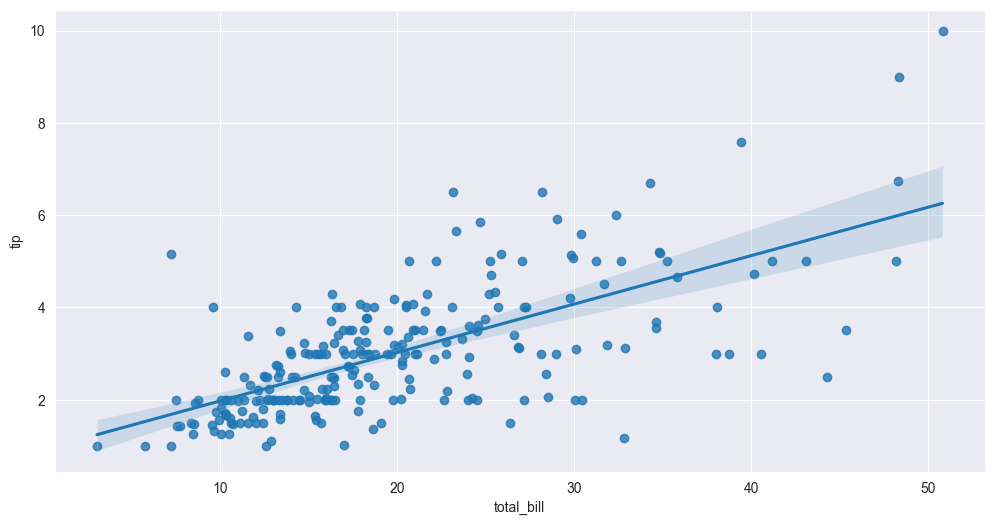

In [22]:
# Our prediction is that as the bill amount increases
# so does the tip. Create a regression line to check
# Load tip dataset
tips = sns.load_dataset('tips')
# Create a regression line that averages the results
plt.figure(figsize=(12, 6))
sns.regplot(x='total_bill', y='tip', data=tips)
ax = px.scatter(tips, x='total_bill', y='tip', trendline='ols')
ax.show()

# Regression Time Series Example with AutoReg

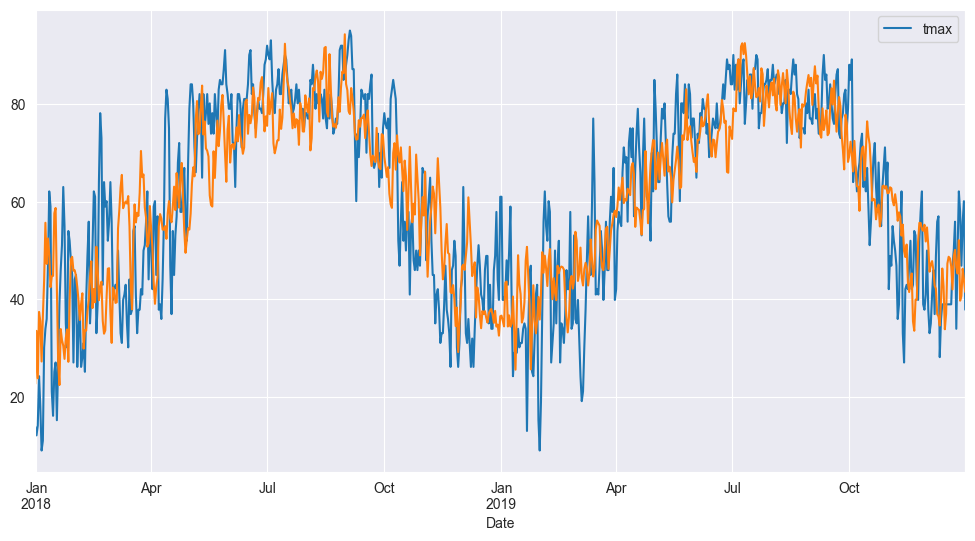

In [54]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics

pitt_df = pd.read_csv('PittsburghWeather.csv', index_col='Date', parse_dates=True)
pitt_df = pitt_df.drop(['tmin', 'prcp'], axis=1)

# Get data since 2010
pitt_df = pitt_df[pitt_df.index>'2010-01-01']
pitt_df = pitt_df.asfreq('d') # Change frequency to day
pitt_df = pitt_df.fillna(method='ffill')
pitt_df.index # Check frequency
pitt_df.isnull().values.any() # Check for NaNs

# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(12, 6))

# Plot daily max temps
fig, ax = plt.subplots()
# ax = pitt_df.plot(ax=ax)

# Create our model using whole data set
model = AutoReg(pitt_df['tmax'], 30)
model_fit = model.fit()

# Define training and testing area
len(pitt_df) # 3651 observations
train_df = pitt_df.iloc[:2920] # 80%
test_df = pitt_df.iloc[2920:] # Last 20%

# Define training model for 730 days and White's covariance
# estimator
train_model = AutoReg(train_df['tmax'], 730).fit(cov_type="HC0")

start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax)
ax = prediction.plot(ax=ax)

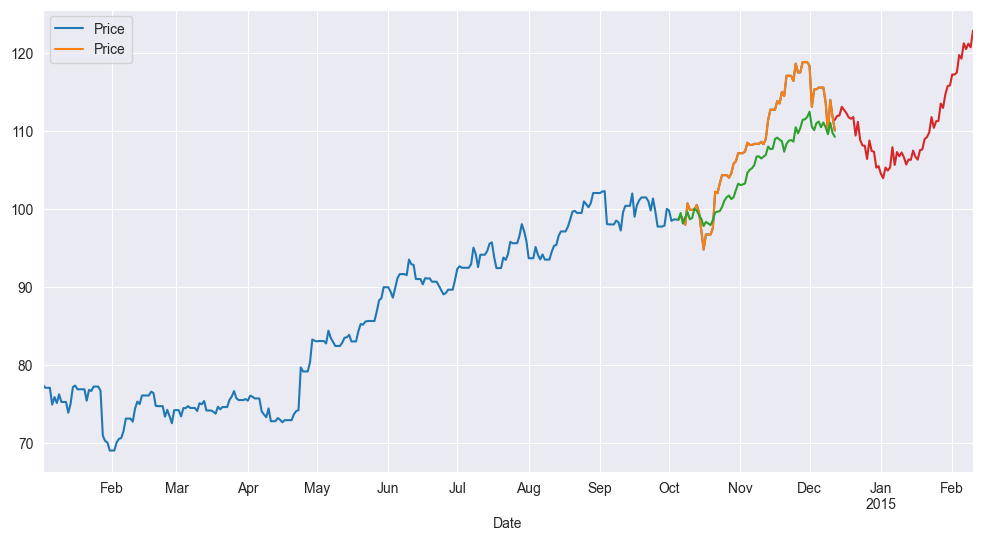

In [56]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

appl_df = pd.read_csv('appl2.csv', index_col='Date', parse_dates=True)

appl_df = appl_df.asfreq('d') # Change frequency to day
appl_df = appl_df.fillna(method='ffill')
appl_df.index # Check frequency
appl_df.isnull().values.any() # Check for NaNs

# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(12, 6))

# Plot daily max temps
fig, ax = plt.subplots()
ax = appl_df.plot(ax=ax)

# Create our model using whole data set
model = AutoReg(appl_df['Price'], 30)
model_fit = model.fit()

# Define training and testing area
len(appl_df) # 345 observations
train_df = appl_df.iloc[:276] # 80%
test_df = appl_df.iloc[276:] # Last 20%

# Define training model for 100 days and White's covariance
# estimator
train_model = AutoReg(appl_df['Price'], 100).fit(cov_type="HC0")

# Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # Orange
ax = prediction.plot(ax=ax) # Green

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+60, dynamic=True)
ax = forecast.plot(ax=ax) # Red


# ARIMA (Integrated):

- I (Integrated) focuses on replacing values with the differences between previous values. Differencing is the computing of the differences between consecutive values. The goal is to make the time series stationary.

- A stationary series has a constant mean and variance.

# Stationary Datasets

Dickey-Fuller Test
Test Statistic                -1.251942e+01
p-value                        2.568080e-23
#Lags Used                     3.300000e+01
Number of Observations Used    5.444000e+03
dtype: float64
Dickey-Fuller Test
Test Statistic                  -0.339865
p-value                          0.919665
#Lags Used                       0.000000
Number of Observations Used    239.000000
dtype: float64


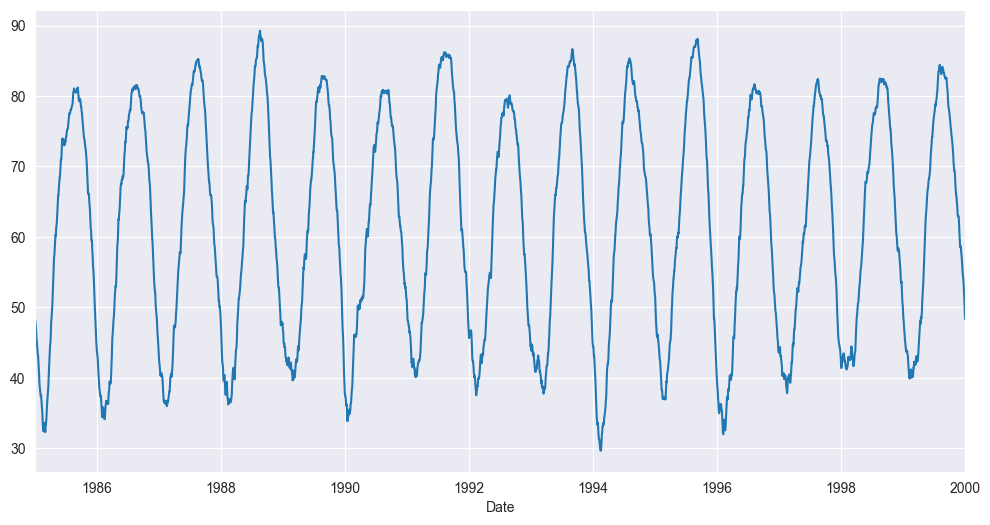

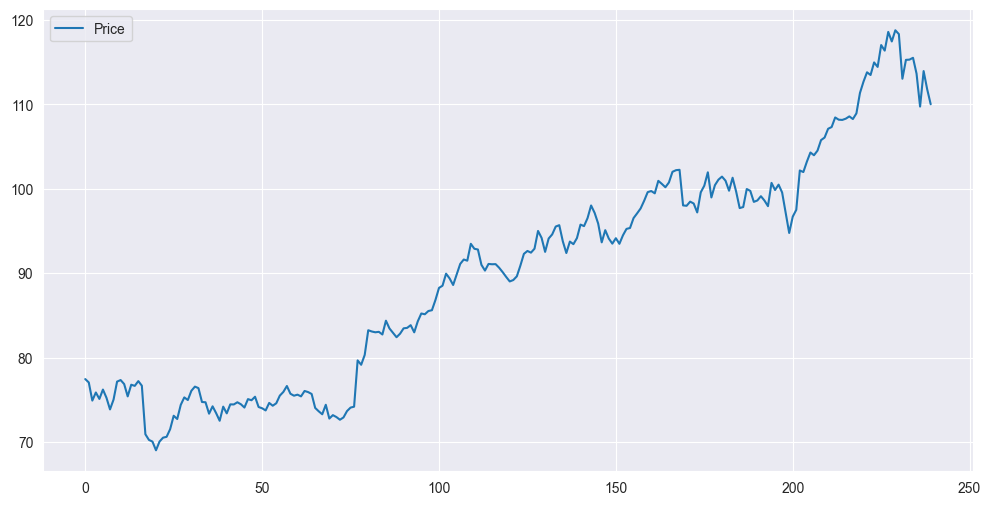

In [66]:
# Your data must be transformed to stationary form to be able to evaluate it

# Used to measure whether our data is stationary
from statsmodels.tsa.stattools import adfuller

# Stationary data is rather flat and the mean, variance 
# and autocorrelation structure do not change over time.

# This data isn't perfect because variance is changing
pitt_df = pd.read_csv('PittsburghWeather.csv', 
                      index_col='Date', parse_dates=True)
# pitt_df['tmax'].plot(xlim=['1985-01-01','2000-01-01'])

# Flatten it out a bit by finding the mean
df_2 = pitt_df.rolling(window=60).mean()['tmax']
# Mask off dates and return them to the dataframe
mask = (df_2.index > '1985-01-01') & (df_2.index <= '2000-01-01')
df_2 = df_2.loc[mask]
df_2.plot()

# Example of non-stationary data US Birth rates 30-34
usbr_df = pd.read_csv('US-Birth-Rates.csv', 
                      index_col='Year', parse_dates=True)
# usbr_df['30-34'].plot()

# Another non-stationary example
# Import stock data from a CSV file
df_appl = pd.read_csv('appl2.csv')
df_appl.plot()

# The Augmented Dickey-Fuller Test tells us whether our results
# are stationary. If the P-Value is very small that means
# there is a very low probability that our results are random
def adf_test(timeseries):
    print ('Dickey-Fuller Test')
    # AIC aims to minimize corresponding information
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print (dfoutput)

# Highly stationary (Low P-Value)
adf_test(df_2)

# Not stationary (High P-Value)
adf_test(df_appl['Price'])